In [1]:
import cv2 
import numpy as np
import imutils
from scipy import ndimage
from scipy.spatial import distance

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

## https://www.geeksforgeeks.org/opencv-python-tutorial/#images

In [3]:
# some global params
blocksize = 5 # for adaptiveThreshold. based on image size and resolution. some sort of smoothing size. keep it odd. 
thresholding_binary_value = 3 # for cv2.adaptiveThreshold based on details in the original pic. 3 for high detail... otherwise increase it. keep it odd.

sub_image_size=2048 # size of block to cut out to zoom in.

dpi=120

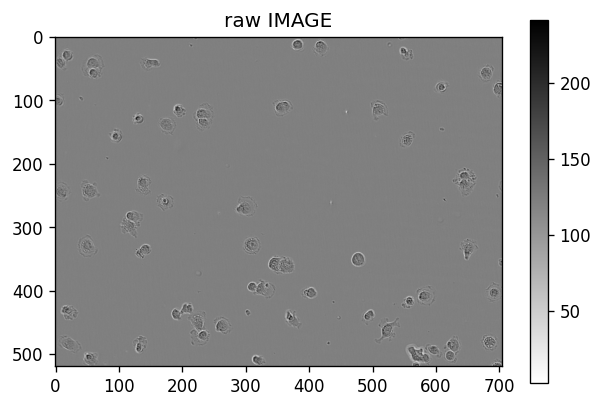

In [4]:
rootdir="/Users/hershalpandya/data/temp_delete/images/livecell_train_val_images/A172/"
img = cv2.imread(rootdir+'A172_Phase_A7_1_00d00h00m_1.tif')
img = img[:sub_image_size,:sub_image_size]

plt.figure(dpi=dpi)
plt.imshow(img,cmap='binary')
plt.title("raw IMAGE")
temp=plt.colorbar()

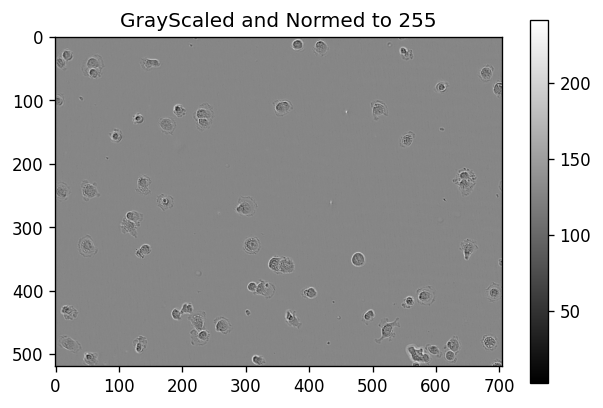

In [5]:
# when you do this, the range is automatically changed to 0 to 255
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(dpi=dpi)
plt.title("GrayScaled and Normed to 255")
plt.imshow(img,cmap='gray')
temp=plt.colorbar()

In [6]:
# adaptively calculates threshold across the image to return an array of same shapee as src image. 

thresh_mean = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                          cv2.THRESH_BINARY, thresholding_binary_value, blocksize)
  
# both perform almost same. We'll go with mean. 
thresh_gauss = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, thresholding_binary_value, blocksize)

Text(0.5, 1.0, 'Adaptive Gaussian')

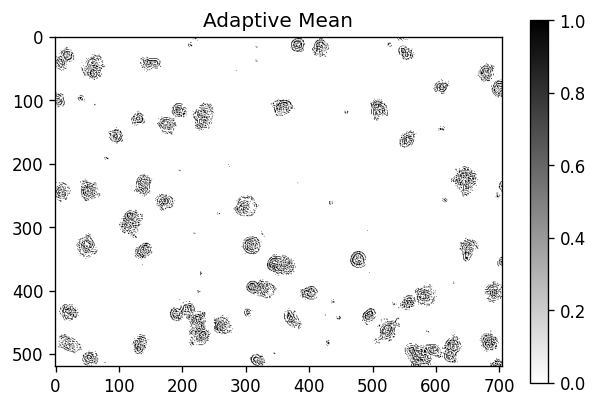

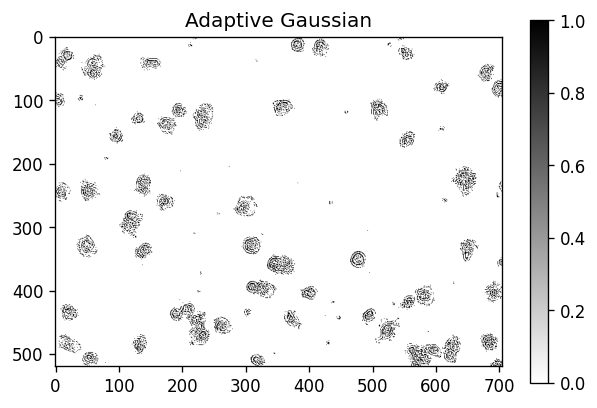

In [7]:
# the window showing output images
# with the corresponding thresholding 
# techniques applied to the input image
plt.figure(dpi=dpi)
plt.imshow(img>thresh_mean,cmap='binary')
plt.colorbar()
plt.title('Adaptive Mean')

plt.figure(dpi=dpi)
plt.imshow(img>thresh_gauss,cmap='binary')
plt.colorbar()
plt.title('Adaptive Gaussian')

In [8]:
mask=1.0*(img>thresh_gauss)
img = np.asarray(img, np.float64)
mask = np.asarray(mask, np.float64)
print (mask.shape,img.shape)

img_thresh=cv2.multiply(img,mask)
img_thresh/=np.max(img_thresh)

(520, 704) (520, 704)


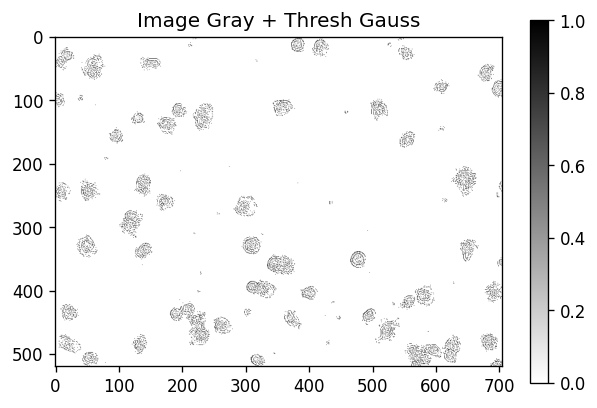

In [9]:
plt.figure(dpi = 120)
plt.title("Image Gray + Thresh Gauss")
plt.imshow(img_thresh,cmap='binary')
plt.colorbar()

In [10]:
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))

img_thresh_blur  = cv2.GaussianBlur(img_thresh, (5, 5), 0)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
img_thresh_dilated = cv2.dilate(img_thresh_blur, kernel, iterations=3)

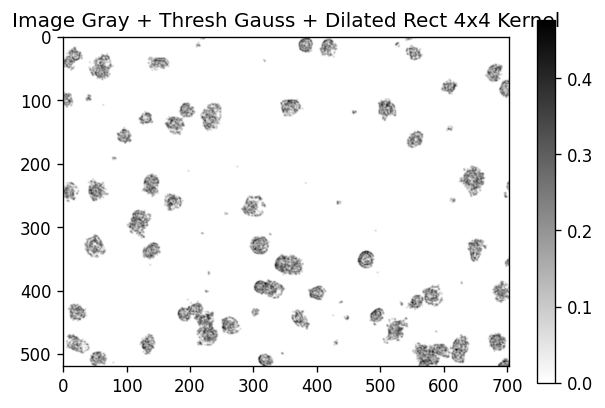

In [11]:
plt.figure(dpi = 120)
plt.title("Image Gray + Thresh Gauss + Dilated Rect 4x4 Kernel")
plt.imshow(img_thresh_dilated,cmap='binary')
plt.colorbar()

(366080,) (366080,)


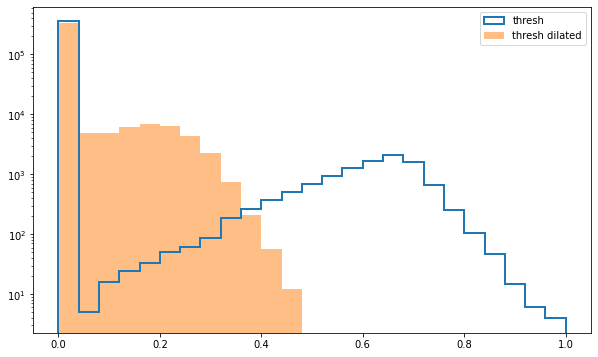

In [12]:
plt.figure(figsize=(10,6))

temp=plt.hist(img_thresh.ravel(), range=[0,1],
              bins=25,log=True,
              alpha=1.0,label='thresh',
              histtype='step',lw=2.0,color='C0')

temp=plt.hist(img_thresh_dilated.ravel(),range=[0,1],
              bins=25,log=True,
              alpha=0.5,
              label='thresh dilated',color='C1')

print (img_thresh_dilated.ravel().shape, img_thresh.ravel().shape)
plt.legend()

In [13]:
img_for_segmenting = img
img_for_finding_centers = img_thresh_dilated

In [14]:
img_to_label = img_for_finding_centers
img_to_label[img_to_label!=0]=1

connectivity = ndimage.generate_binary_structure(2,2)
labels, n_labels = ndimage.label(img_to_label, connectivity)

crosses_x_, crosses_y_ = np.array([np.round(np.mean(np.argwhere(labels==i),axis=0),0) for i in range(n_labels)]).T
old_ids_ = np.arange(len(crosses_x_))
print (crosses_x_.shape, crosses_y_.shape)

(86,) (86,)


In [15]:
distance_to_edges = np.array([np.min([crosses_x_[i],
                                      crosses_y_[i],
                                      np.absolute(crosses_x_[i] - labels.shape[0]), 
                                      np.absolute(crosses_y_[i] - labels.shape[1])
                                     ])
                             for i in range(len(crosses_x_))
                             ])
select_cells = distance_to_edges>32

In [16]:
np.sum(img_for_finding_centers[labels==131]), np.sum(img_for_finding_centers[labels==124])

(0.0, 0.0)

In [17]:

crosses = np.array([crosses_x_, crosses_y_]).T
print (crosses.shape)

pdistances = distance.squareform(distance.pdist(crosses))

keep_one_cross = np.argwhere(pdistances<=32)
keep_one_cross = np.array([i for i in keep_one_cross if i[0]!=i[1]])
# print (keep_one_cross)
# keep_one_cross = np.unique(np.sort(keep_one_cross,axis=1),axis=0)

# print (keep_one_cross)

remove_crosses=[]
for i in keep_one_cross:
    
    if i[0] in remove_crosses or i[1] in remove_crosses:
        continue
        
    s0= np.sum(img_for_finding_centers[labels==i[0]])
    s1= np.sum(img_for_finding_centers[labels==i[1]])
        
    if i[0]==131 or i[1]==131:
        print (i, s0, s1, remove_crosses)

    if s0<=s1:
        remove_crosses.append(i[0])
#         print (i[0])
    else:
        remove_crosses.append(i[1])
#         print (i[1])

remove_cells2 = np.array([i in remove_crosses for i in range(len(crosses_x_))])
select_cells2 = ~remove_cells2

print (np.sum(select_cells2), np.sum(select_cells))

(86, 2)
72 60


In [18]:
print (np.argwhere(select_cells&select_cells2).ravel().shape)

(52,)


In [19]:
np.argwhere(remove_cells2).ravel()
np.argwhere(~select_cells).ravel()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 15, 17, 18, 36, 37, 39, 55,
       60, 68, 77, 78, 80, 82, 83, 84, 85])

In [20]:
crosses_x = crosses_x_[select_cells&select_cells2]
crosses_y = crosses_y_[select_cells&select_cells2]
old_ids = old_ids_[select_cells&select_cells2]

In [21]:
# keep_one_cross

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
(520, 704) (3, 3) (520, 704) 86


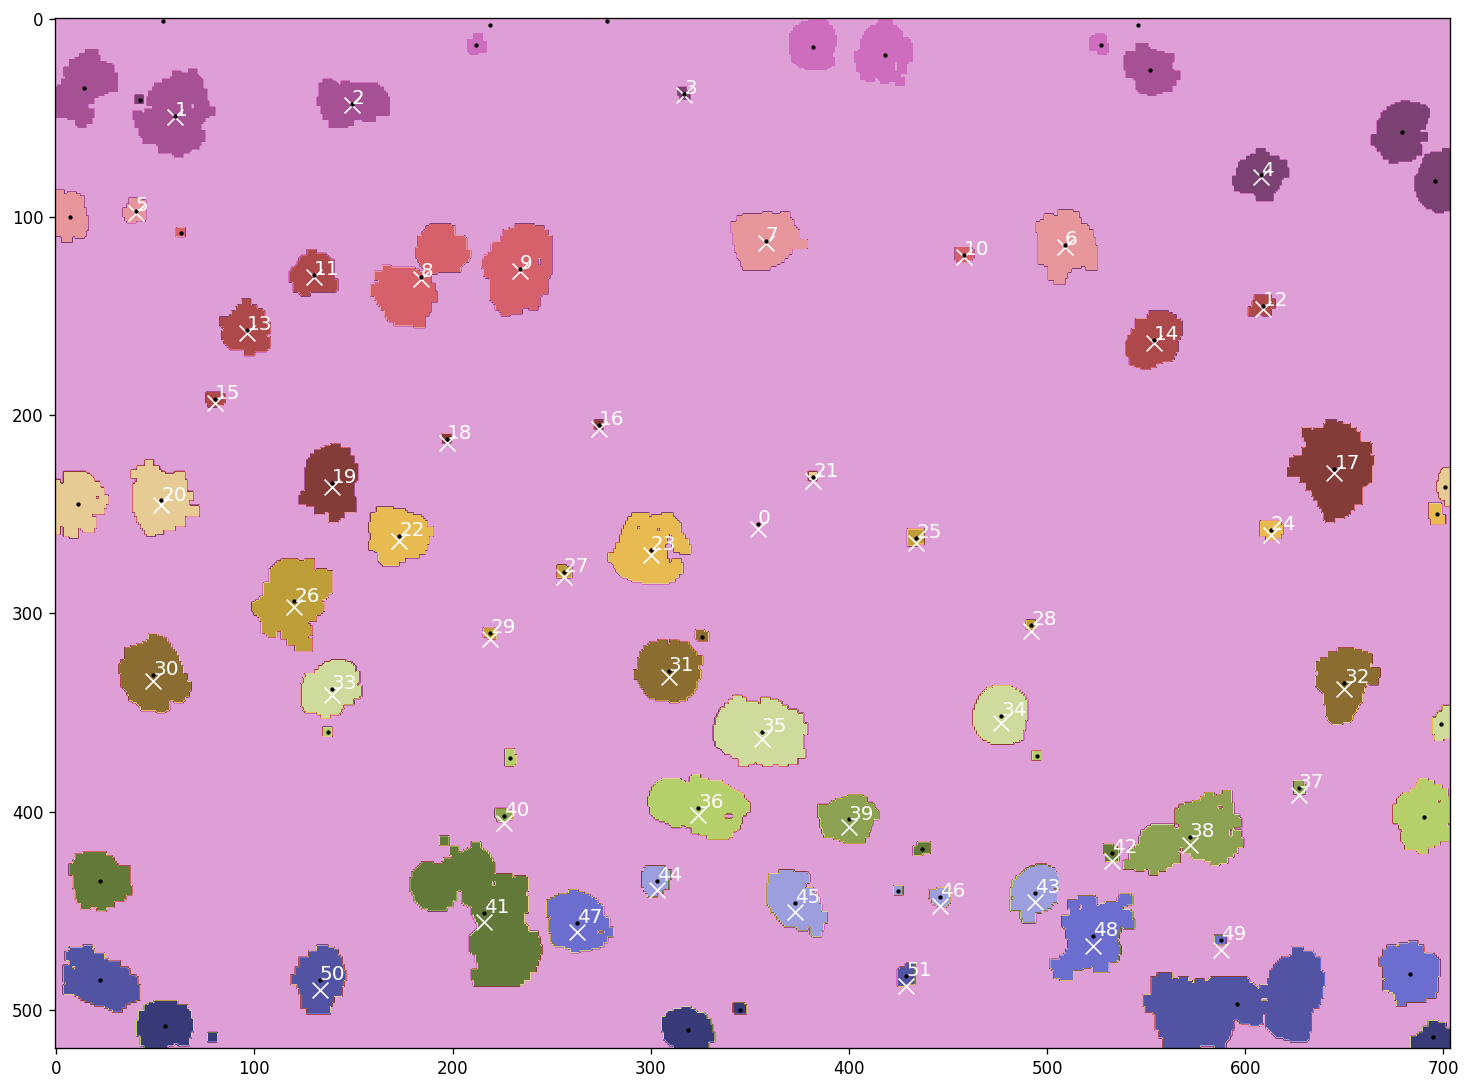

In [22]:
print (connectivity)
print (img_for_finding_centers.shape, connectivity.shape, labels.shape, n_labels)

cid_start=0
cid_stop=len(crosses_y)#cid_start+5

plt.figure(dpi=1*dpi,figsize=(15,15))
plt.imshow(labels,cmap='tab20b_r')
# plt.colorbar()
plt.scatter(crosses_y[cid_start:cid_stop], 
            crosses_x[cid_start:cid_stop]*1.01,
            s=90,c='w',marker='x',lw=1)
for cid in range(cid_start,cid_stop):
    plt.text(crosses_y[cid],
             crosses_x[cid],
             cid,fontsize=12,c='w')

plt.scatter(crosses_y_, crosses_x_,s=10,c='k',marker='.')
# for cid in np.arange(len(crosses_y_))[select_cells]:
#     plt.text(crosses_y_[cid],crosses_x_[cid],
#              cid,fontsize=12,c='grey',alpha=0.6)

# plt.xlim([250,350])
# plt.ylim([200,300])

56


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


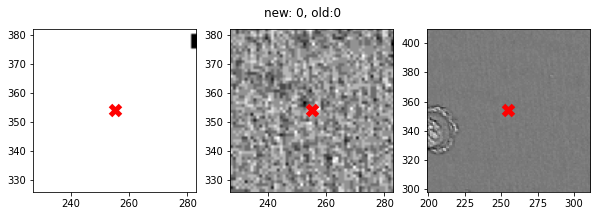

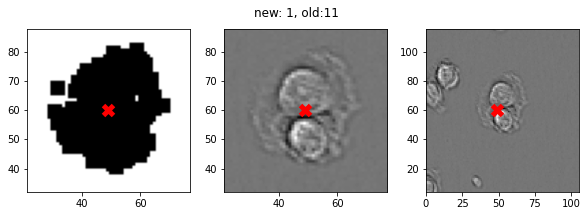

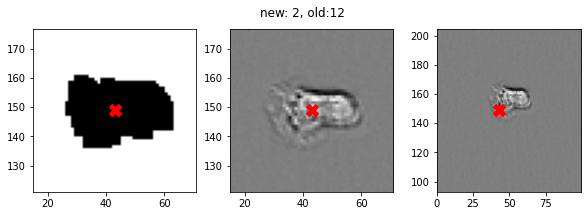

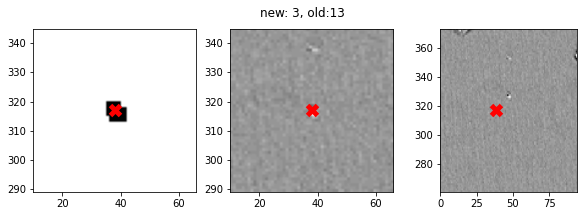

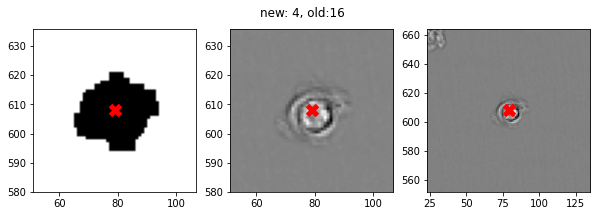

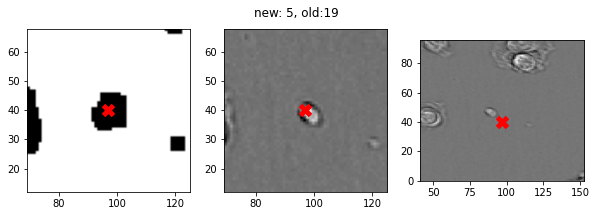

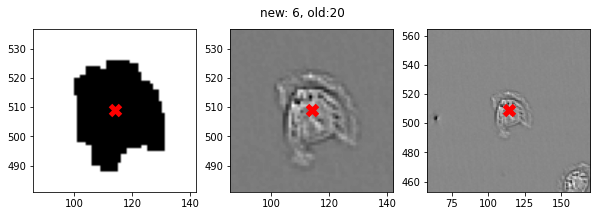

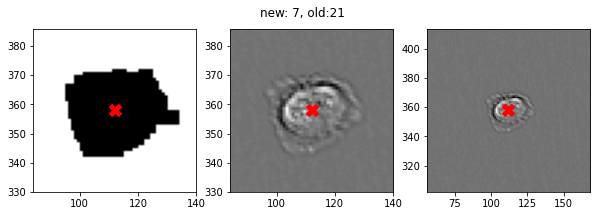

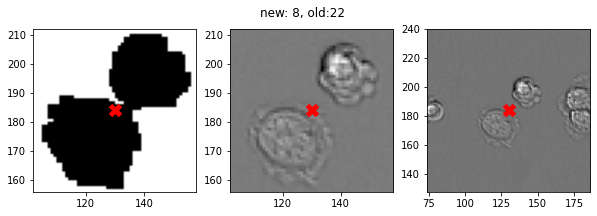

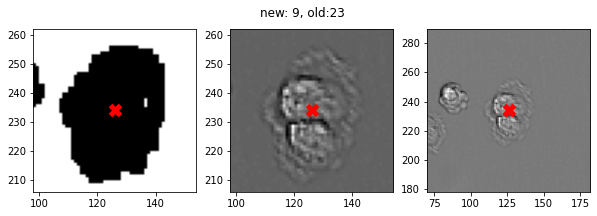

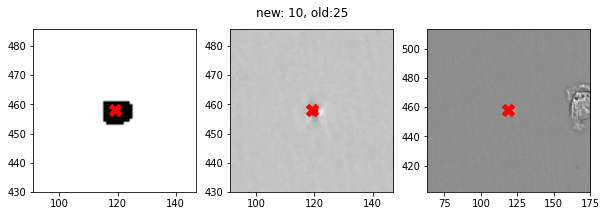

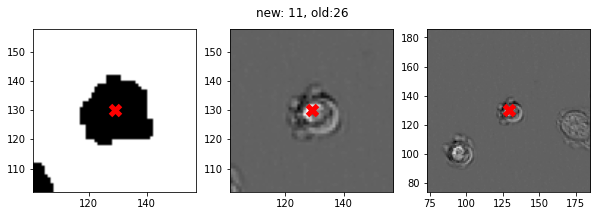

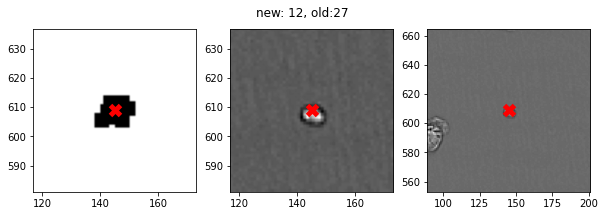

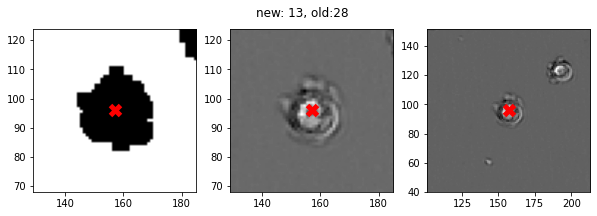

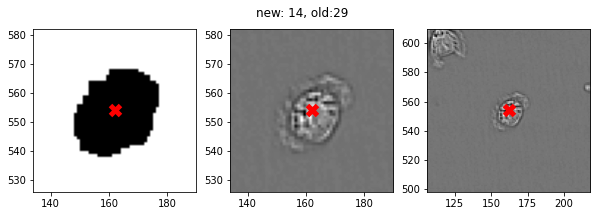

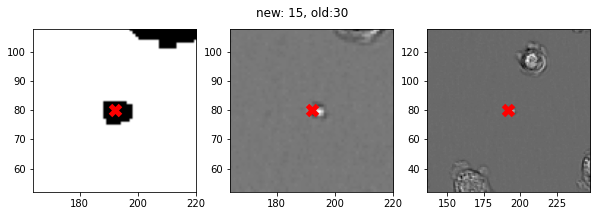

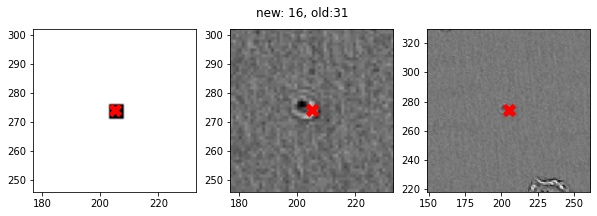

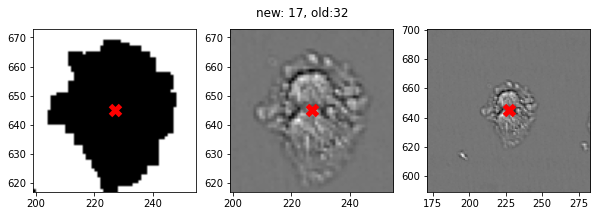

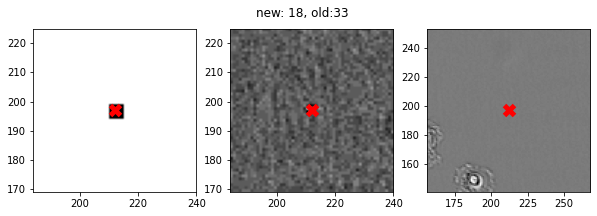

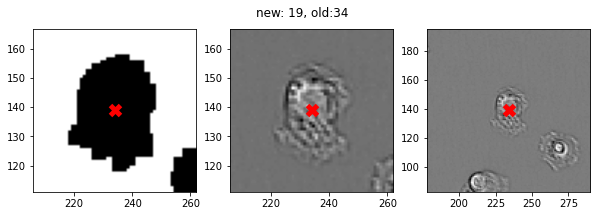

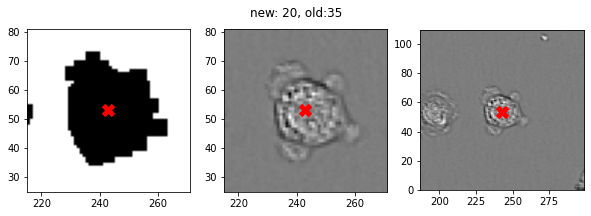

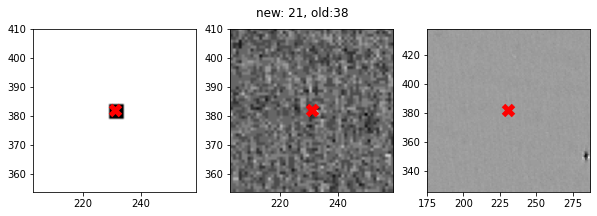

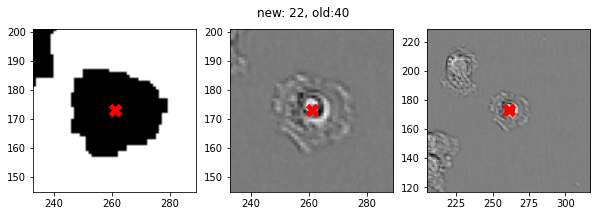

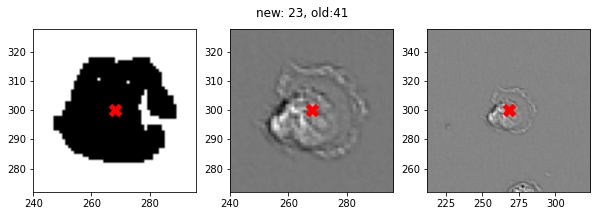

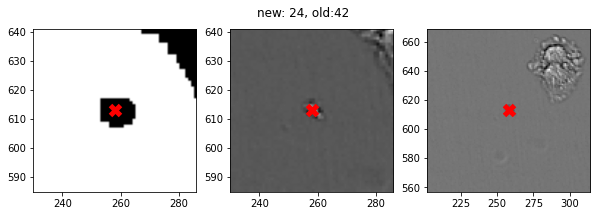

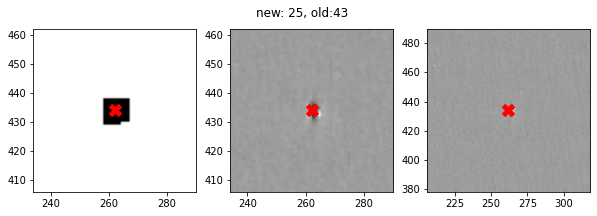

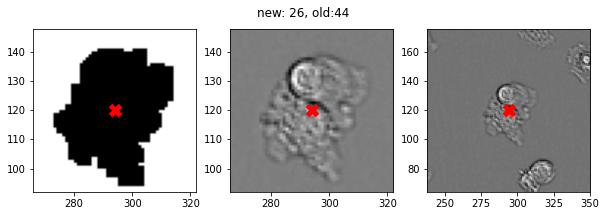

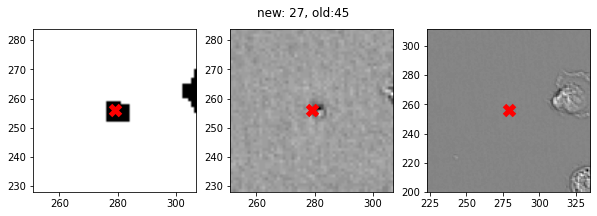

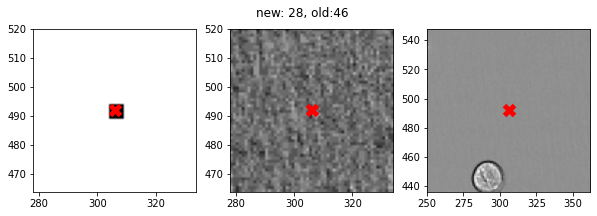

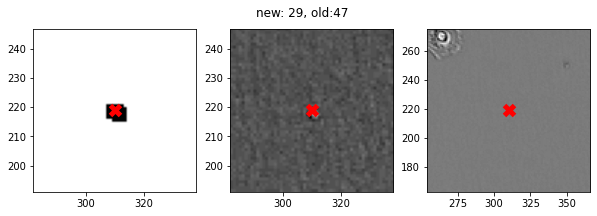

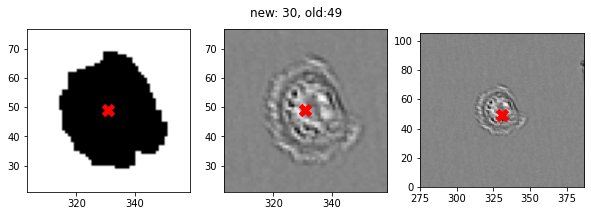

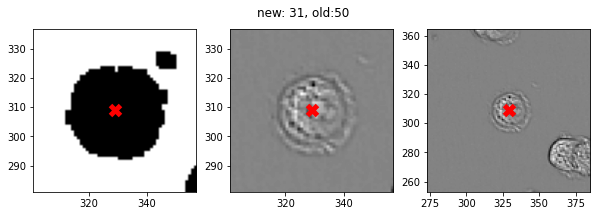

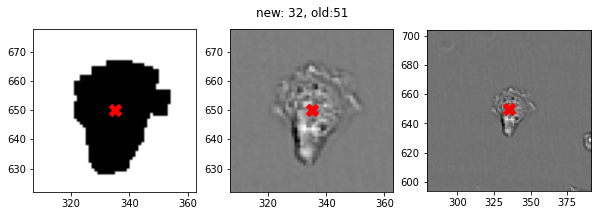

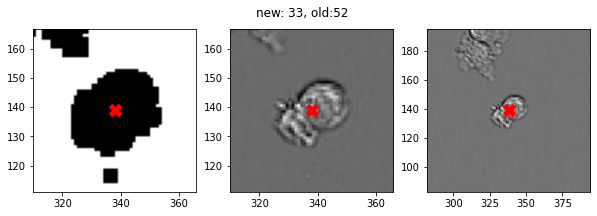

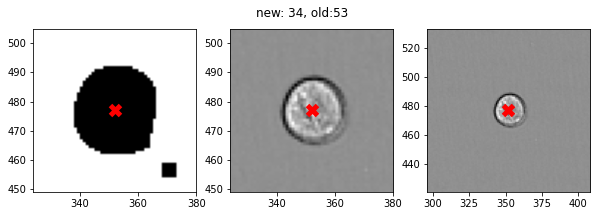

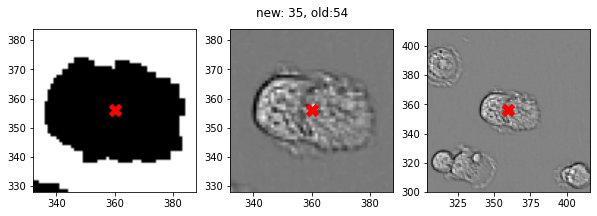

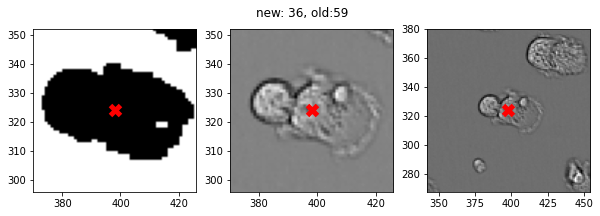

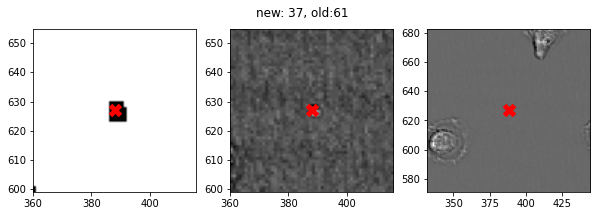

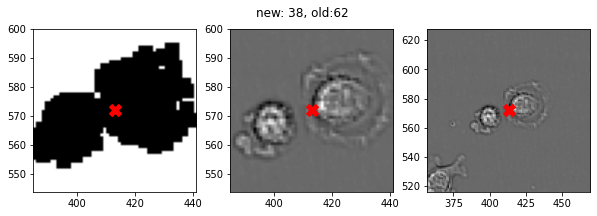

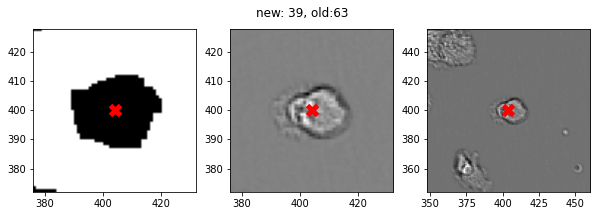

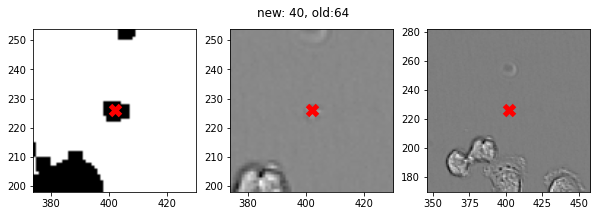

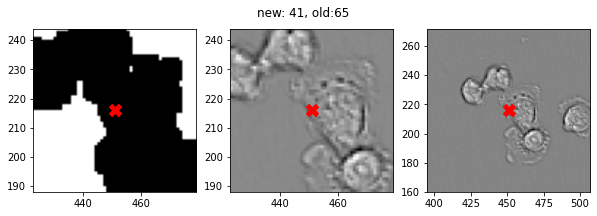

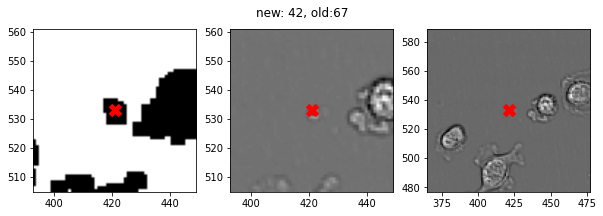

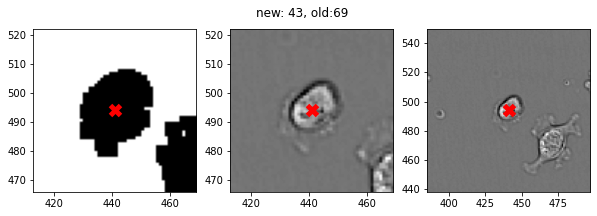

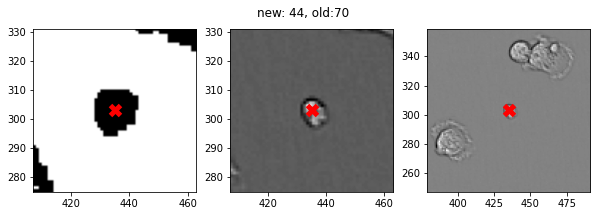

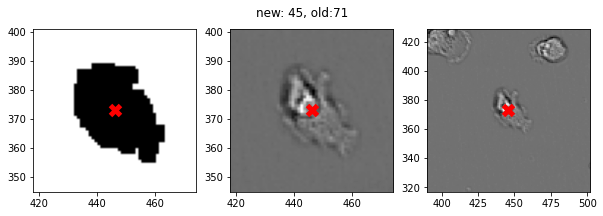

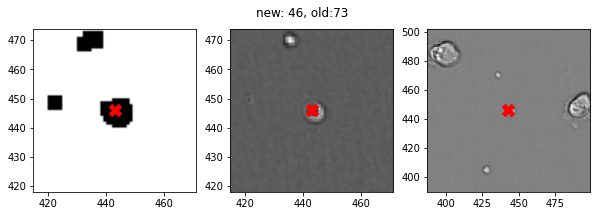

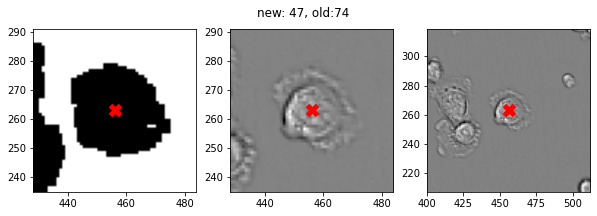

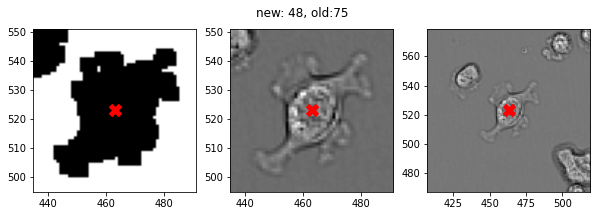

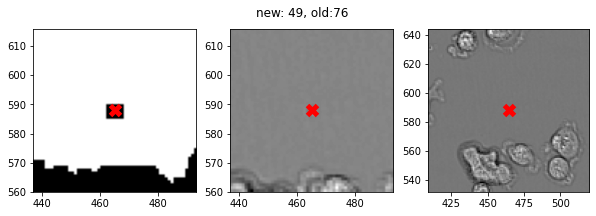

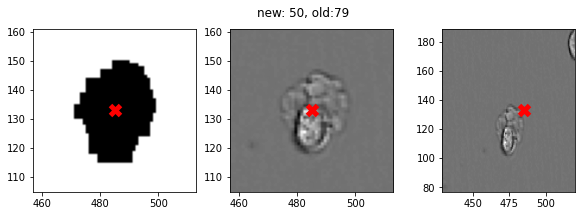

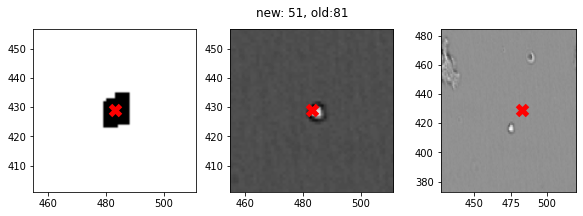

In [23]:
s=28 # size of block to cut
print (s*2)

for i in range(cid_start,cid_stop):#,21,22,23,24]:#,20,5,10]:
    
#     fig, (ax1,ax2,ax3) = plt.subplots(1, 3,dpi=dpi)
    
    n=int(crosses_x[i])
    m=int(crosses_y[i])
    
    cross_x = n
    cross_y = m
    
    ln=np.max( [n-s,0] )
    hn=np.min( [n+s, img_for_finding_centers.shape[0] ] )
    
    lm=np.max( [m-s,0] )
    hm=np.min( [m+s, img_for_finding_centers.shape[1] ] )
    
    extent = [ln,hn,lm,hm]

    
    this_img = img_for_finding_centers[ln:hn,lm:hm]
    this_img2 = img_for_segmenting[ln:hn,lm:hm]
    
    lln=np.max( [n- 2*s,0] )
    hhn=np.min( [n+ 2*s, img_for_finding_centers.shape[0] ] )
    
    llm=np.max( [m- 2*s,0] )
    hhm=np.min( [m+ 2*s, img_for_finding_centers.shape[1] ] )
    extent3 = [lln,hhn,llm,hhm]
    
    this_img3 = img_for_segmenting[lln:hhn,llm:hhm]
    

    plt.figure(figsize=(10,3))
    plt.suptitle("new: "+str(i)+", old:"+str(old_ids[i]))
    
    plt.subplot(131)
    plt.imshow(this_img,cmap='binary',extent=extent)
#     plt.colorbar()
    # y,x scatter because imshow flips axes
    plt.scatter([cross_x],[cross_y],s=100,c='r',marker='x',lw=5)
#     plt.text(cross_x,cross_y,i,fontsize=14,c='r')


#     plt.figure()
    plt.subplot(132)
#     plt.title(i) 
    plt.imshow(this_img2,cmap='binary',extent=extent)
#     plt.colorbar()
    # y,x scatter because imshow flips axes
    plt.scatter([cross_x],[cross_y],s=100,c='r',marker='x',lw=5)
#     plt.text(cross_x,cross_y,i,fontsize=14,c='w')

    
    plt.subplot(133)
#     plt.title(i)
    plt.imshow(this_img3,cmap='binary',extent=extent3)
#     plt.colorbar()
    # y,x scatter because imshow flips axes
    plt.scatter([cross_x],[cross_y],s=100,c='r',marker='x',lw=5)
#     plt.text(cross_x,cross_y,i,fontsize=14,c='w')